In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import TensorDataset
import numpy as np

from src.gan.generator import Generator
from src.gan.discriminator import Discriminator

from src.data_loaders.datasets.fashion_mnist_dataset import FashionMNISTDataset
from src.data_loaders.datasets.generated_fake_dataset import GeneratedFakeDataset
from src.data_loaders.datasource import show_images_from_tensor

In [2]:
device = torch.device("cuda:0")

In [3]:
#models
latent_dim = 32
generator = Generator(latent_dim=latent_dim, hidden_dim=40, output_dim=784).to(device)
discriminator = Discriminator(hidden_dim=40, input_dim=784).to(device)

In [4]:
generator.load_state_dict(torch.load("../../pre-trained/generator"))
discriminator.load_state_dict(torch.load("../../pre-trained/discriminator"))

<All keys matched successfully>

In [5]:
fashionMNIST = FashionMNISTDataset()
train_data_real = fashionMNIST.train_data

generated_fake_dataset = GeneratedFakeDataset(generator, len(train_data_real))
train_data_fake = generated_fake_dataset.train_dataset

train_data_merged = torch.cat([train_data_real, train_data_fake], 0)

In [6]:
train_targets_real = fashionMNIST.get_train_set_targets()

train_targets_fake = generated_fake_dataset.get_train_set_targets()

train_targets_merged = torch.cat([train_targets_real, train_targets_fake], 0).unsqueeze(1)

In [7]:
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)
criterion = nn.MSELoss()

In [8]:
train_loader = data.DataLoader(TensorDataset(train_data_merged, train_targets_merged), batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
# train_loader = data.DataLoader(TensorDataset(train_data_fake, train_targets_fake), batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
# train_loader = data.DataLoader(TensorDataset(train_data_real, train_targets_real), batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)

In [9]:
def show_sample_predictions(discriminator, my_data_loader_batch):
    show_images_from_tensor(my_data_loader_batch[0].cpu())
    predictions = discriminator(my_data_loader_batch[0].to(device)).cpu()
    print(predictions)
    print(f"Loss: {criterion(predictions.cuda(), my_data_loader_batch[1].cuda())}")

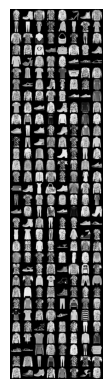

tensor([[ 9.1187e-02],
        [ 9.5190e-01],
        [ 4.3855e-02],
        [-2.6931e-02],
        [-6.5204e-02],
        [ 1.1465e+00],
        [ 9.5577e-01],
        [ 2.1826e-01],
        [ 8.7219e-01],
        [ 8.6980e-01],
        [ 1.1682e+00],
        [ 2.8696e-01],
        [ 1.0773e+00],
        [ 1.0997e+00],
        [ 2.3677e-01],
        [ 4.9288e-01],
        [ 8.0853e-02],
        [-1.9295e-01],
        [ 2.7442e-01],
        [ 9.6964e-03],
        [ 1.3108e+00],
        [ 3.4037e-01],
        [ 1.0039e+00],
        [ 9.6687e-02],
        [ 8.0191e-02],
        [ 6.8633e-02],
        [ 5.8866e-01],
        [ 9.1527e-01],
        [ 9.9443e-01],
        [ 8.2056e-02],
        [ 5.6191e-02],
        [ 9.8007e-01],
        [ 1.1730e+00],
        [ 9.6333e-01],
        [-7.8768e-02],
        [ 1.4990e-01],
        [ 1.1747e-03],
        [ 8.6706e-01],
        [ 1.0376e+00],
        [ 1.0278e+00],
        [ 8.8994e-03],
        [ 5.9219e-01],
        [ 9.0358e-01],
        [ 7

In [10]:
show_sample_predictions(discriminator, next(iter(train_loader)))

In [11]:
num_epochs = 10
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_acc = []
    discriminator_error = []
    for i, batch in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        images = batch[0].to(device)
        b_size = images.size(0)
        # label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        label = batch[1].float().to(device)
        # Forward pass real batch through D
        output = discriminator(images).view(-1)
        # Calculate loss on all-real batch
        error_discriminator = criterion(output, label)
        discriminator_error.append(error_discriminator.mean().item())
        # Calculate gradients for D in backward pass
        error_discriminator.backward()
        discriminator_acc.append(output.mean().item())
        # Update D
        discriminator_optimizer.step()
    print(f"Epoch: {epoch}, discriminator mean output: {np.mean(discriminator_acc):.3}")
    print(f"Epoch: {epoch}, discriminator mean error: {np.mean(discriminator_error):.3}")

C:\inz\nDES-thesis\venv\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, discriminator mean output: 0.505
Epoch: 0, discriminator mean error: 0.27
Epoch: 1, discriminator mean output: 0.501
Epoch: 1, discriminator mean error: 0.257
Epoch: 2, discriminator mean output: 0.5
Epoch: 2, discriminator mean error: 0.255


RuntimeError: DataLoader worker (pid(s) 8556, 18920, 16940, 19136) exited unexpectedly

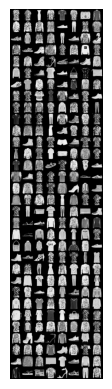

tensor([[0.5117],
        [0.4682],
        [0.4388],
        [0.4230],
        [0.5308],
        [0.5203],
        [0.4130],
        [0.4873],
        [0.4831],
        [0.4522],
        [0.5418],
        [0.4319],
        [0.5129],
        [0.4496],
        [0.4875],
        [0.4467],
        [0.5152],
        [0.4357],
        [0.5225],
        [0.4308],
        [0.4823],
        [0.5041],
        [0.4907],
        [0.4238],
        [0.4486],
        [0.4367],
        [0.5184],
        [0.4476],
        [0.4741],
        [0.4738],
        [0.3068],
        [0.4910],
        [0.4799],
        [0.4683],
        [0.4479],
        [0.5971],
        [0.4238],
        [0.4560],
        [0.4865],
        [0.4446],
        [0.4775],
        [0.4415],
        [0.4987],
        [0.5367],
        [0.4951],
        [0.5151],
        [0.6178],
        [0.3478],
        [0.5014],
        [0.3852],
        [0.4647],
        [0.5103],
        [0.5519],
        [0.6321],
        [0.3983],
        [0

In [12]:
show_sample_predictions(discriminator, next(iter(train_loader)))

In [13]:
print(train_targets_fake)

tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [47]:
print(train_targets_fake)

tensor([0., 0., 0.,  ..., 0., 0., 0.])


# Wniosek -> dyskriminator się nie uczy nawet na zwykłym gradiencie